In [1]:
import sys
import cv2
import bunch
sys.path.append('../')
from Dataset.DefaultDataset import TFDataset
from Dataset.UnlabeledDataset import TFDataset as UnlabeledDataset
from utils.config import process_config

import matplotlib.pyplot as plt
import numpy as np
import tensorflow_addons as tfa

import tensorflow as tf

In [2]:
config = {
  "exp_name": "noisy_student_full_throttle",

  "landmark_path": "../../../data-archive/landmark-tfr/",
  "unlabeled_path": "../../../data-archive/landmark-tfr/unlabeled",

  "img_size": 192,
  "n_channel": 3,

  "learning_rate": 0.0001,
  "num_epochs": 150,
  "batch_size": 32
}

config = bunch.Bunch(config)
ds = TFDataset(config, 'test')

dataset = ds.dataset

iterator = dataset.as_numpy_iterator()


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [3]:
def eul2rot(theta):
    R = tf.cast([
        [tf.cos(theta[1]) * tf.cos(theta[2]),
         tf.sin(theta[0]) * tf.sin(theta[1]) * tf.cos(theta[2]) - tf.sin(theta[2]) * tf.cos(theta[0]),
         tf.sin(theta[1]) * tf.cos(theta[0]) * tf.cos(theta[2]) + tf.sin(theta[0]) * tf.sin(theta[2])],
        [tf.sin(theta[2]) * tf.cos(theta[1]),
         tf.sin(theta[0]) * tf.sin(theta[1]) * tf.sin(theta[2]) + tf.cos(theta[0]) * tf.cos(theta[2]),
         tf.sin(theta[1]) * tf.sin(theta[2]) * tf.cos(theta[0]) - tf.sin(theta[0]) * tf.cos(theta[2])],
        [-tf.sin(theta[1]),
         tf.sin(theta[0]) * tf.cos(theta[1]),
         tf.cos(theta[0]) * tf.cos(theta[1])]],
        tf.float32)
    return R

def rot2eul(R):
    sy = tf.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
    x = tf.atan2(R[2, 1], R[2, 2])
    y = tf.atan2(-R[2, 0], sy)
    z = tf.atan2(R[1, 0], R[0, 0])
    return [z, y, x]

def rotate_headpose(headpose):
    theta = 3.14159265 / 3 #tf.random.uniform([], -3.14159265, 3.14159265)
        
    R_z = rotation_matrix([1,0,0], theta)

    R = np.reshape(((np.cos(theta), -np.sin(theta)),
                    (np.sin(theta), np.cos(theta))), (2,2))

    temp_rot = eul2rot(headpose)
    new_rmat = np.matmul(temp_rot, R_z)
    headpose = rot2eul(new_rmat)
    return headpose

def rotation_matrix(axis, theta):
#     axis = axis / tf.sqrt(tf.tensordot(axis, axis, 1))
    a = tf.cos(theta/2.)
    b = -1 * tf.sin(theta / 2.0)
    c = 0 * tf.sin(theta / 2.0)
    d = 0 * tf.sin(theta / 2.0)
#     b, c, d = -axis*tf.sin(theta/2.)
#     print(axis)
#     print(b, c, d)

    return [[a*a+b*b-c*c-d*d, 2*(b*c-a*d), 2*(b*d+a*c)],
            [2*(b*c+a*d), a*a+c*c-b*b-d*d, 2*(c*d-a*b)],
            [2*(b*d-a*c), 2*(c*d+a*b), a*a+d*d-b*b-c*c]]


In [4]:
def draw_headposes(image, headpose):
    def eul2rot(theta) :
        R = np.array([[np.cos(theta[1])*np.cos(theta[2]), np.sin(theta[0])*np.sin(theta[1])*np.cos(theta[2]) - np.sin(theta[2])*np.cos(theta[0]), np.sin(theta[1])*np.cos(theta[0])*np.cos(theta[2]) + np.sin(theta[0])*np.sin(theta[2])],
                      [np.sin(theta[2])*np.cos(theta[1]), np.sin(theta[0])*np.sin(theta[1])*np.sin(theta[2]) + np.cos(theta[0])*np.cos(theta[2]), np.sin(theta[1])*np.sin(theta[2])*np.cos(theta[0]) - np.sin(theta[0])*np.cos(theta[2])],
                      [-np.sin(theta[1]), np.sin(theta[0])*np.cos(theta[1]), np.cos(theta[0])*np.cos(theta[1])]])

        return R

    rmat = eul2rot(headpose)

    points = np.array([[1,0,0], [0,1,0], [0,0,1]])

    points = np.dot(rmat, points.T)
    points = points.T

    points2D = points[:, :2]
    points2D = (points2D * 80 + [120, 120]).astype(np.int)

    cv2.line(image, tuple([120, 120]), tuple(points2D[0]), (1,0,0), 2, lineType=cv2.LINE_AA)
    cv2.line(image, tuple([120, 120]), tuple(points2D[1]), (0,1,0), 2, lineType=cv2.LINE_AA)
    cv2.line(image, tuple([120, 120]), tuple(points2D[2]), (0,0,1), 2, lineType=cv2.LINE_AA)
    
    return image

In [5]:
imgs, [landmarks, hps] = iterator.next()

In [7]:
counter = 0

for x in iterator:
    counter += 1
print(counter)

155


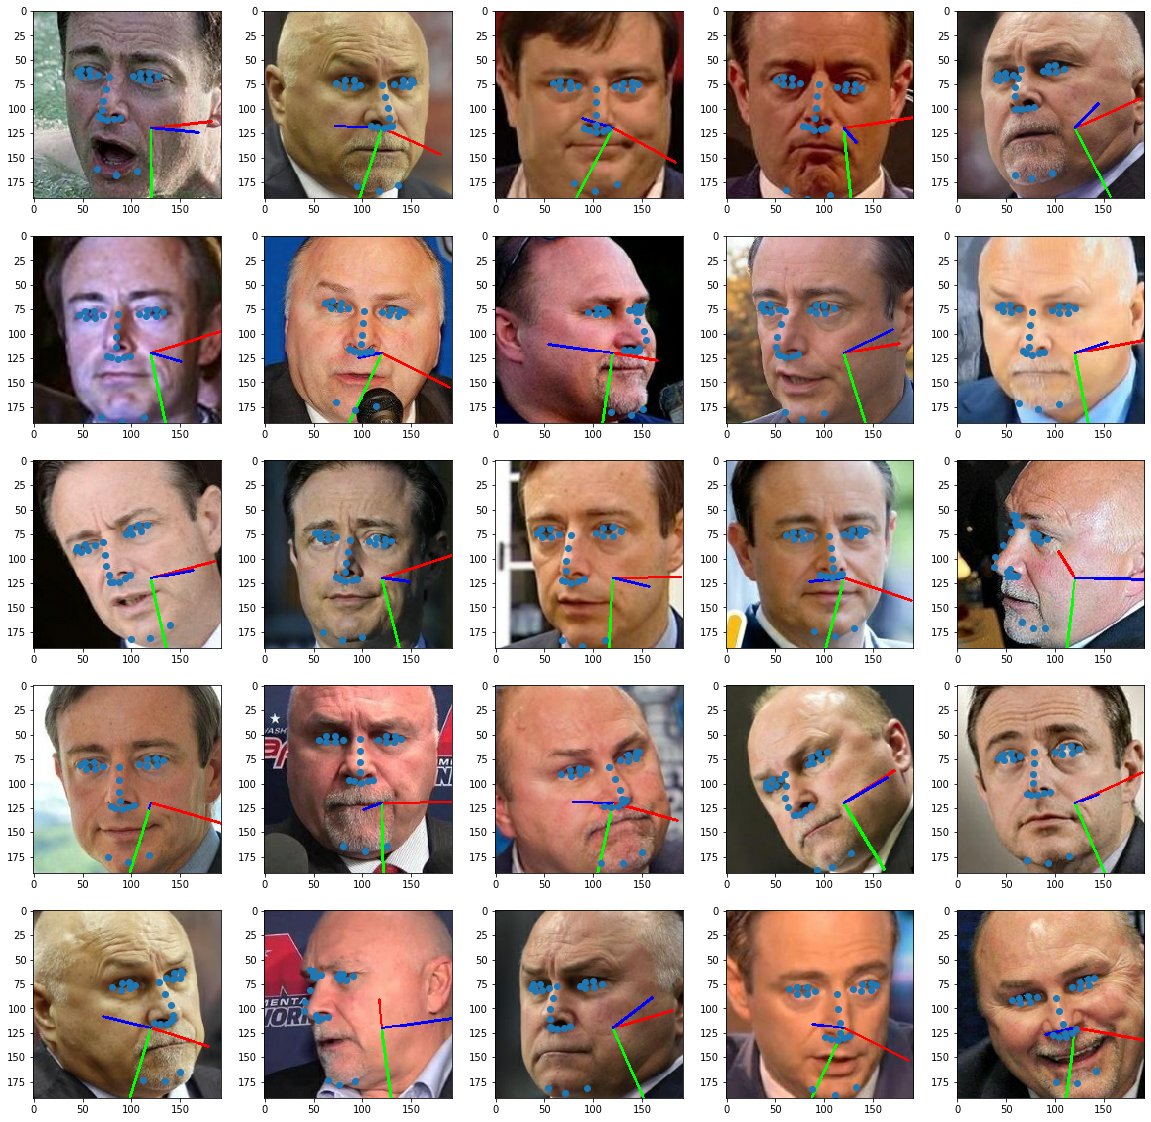

In [6]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

for i in range(25):
    img = imgs[i]
    hp = hps[i]
#     img = original_imgs[i]
#     hp = original_hps[i]
    landmark = landmarks[i]
    
    img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX)
    img = draw_headposes(img, hp)
    
#     print(landmark.shape)
    x, y = np.transpose(landmark)
    axes[i//5][i%5].scatter(x, y)
    axes[i//5][i%5].imshow(img)

In [20]:
152096  // 32

4753

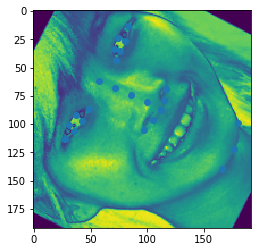

In [94]:
# imgs, lms = iterator.next()

img = imgs[0]
landmark = landmarks[0]

normed = tf.linalg.norm(img, keepdims=True, axis=-1)
normed = tf.reshape(normed, (192, 192))
x, y = np.transpose(landmark)

plt.imshow(normed)
plt.scatter(x, y)

In [95]:
img.shape

(192, 192, 3)

TensorShape([192, 192])

In [102]:
y_pred = tf.random.normal((32, 24, 2))
y_true = tf.random.normal((32, 24, 2))

loss = tf.sqrt(tf.reduce_sum(tf.math.square(y_pred - y_true), axis=-1))

In [104]:
tf.reduce_mean(loss, axis=-1)

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([1.527495 , 1.9518734, 2.0295658, 1.6880003, 1.5592046, 1.7022101,
       1.9148141, 2.0315993, 1.5752057, 1.9251264, 2.065836 , 1.7297374,
       1.8330822, 1.8036757, 1.6083336, 1.8377651, 1.8928148, 1.9537616,
       1.8395466, 1.7978779, 1.4718796, 1.6617861, 1.6646008, 1.7456115,
       1.4993623, 1.6107308, 1.5599313, 1.6672596, 1.6956391, 1.8744287,
       2.1057317, 1.8169268], dtype=float32)>